# Seq2Seq models implementation

## Data Loading

I will use the anki dataset for the translation task. There are a bit more than 178K of translations


In [ ]:
import re
import copy
import torch
import numpy as np
import torch.nn as nn

from matplotlib import pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm

!wget https://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zip

with open("fra.txt") as f:
  sentences = f.readlines()

# number of sentences
len(sentences)


--2020-09-22 12:00:55--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.24.109.196, 104.24.108.196, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6073837 (5.8M) [application/zip]
Saving to: ‘fra-eng.zip.2’

fra-eng.zip.2       100%[===================>]   5.79M  20.7MB/s    in 0.3s    

2020-09-22 12:00:55 (20.7 MB/s) - ‘fra-eng.zip.2’ saved [6073837/6073837]

Archive:  fra-eng.zip
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


178009

## Data Preprocessing

We are going to translate from English to French.

Now I show the distribution of the length for both the translation and the original text.

In [ ]:
#TODO add the normal extraction of sentences from the original lines

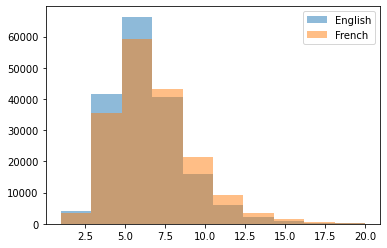

In [ ]:
plt.hist([len(sentence.split("\t")[0].split(' ')) for sentence in sentences], range=(1,20), alpha=0.5, label="English")
plt.hist([len(sentence.split("\t")[1].split(' ')) for sentence in sentences], range=(1,20), alpha=0.5, label="French")
plt.legend(loc='upper right')

As we can see French sentences tend to be longer. Later, when sentences is truncated, the limits will be a bit different

Now, let's preprocess the texts and extract from them preprocessed sentences and the vocabulary

In [ ]:
#TODO increase the length of the sentence

In [ ]:
# Let's shuffle the sentences
np.random.seed(42)
np.random.shuffle(sentences)

In [ ]:
NUM_INSTANCES = 20000
MAX_ENG_LEN = 8
MAX_FRE_LEN = 9
eng_sentences, fre_sentences = [], []
eng_words, fre_words = set(), set()
for i in tqdm(range(NUM_INSTANCES)):
  # find only letters in sentences
  eng_sent, fre_sent = ["<sos>"], ["<sos>"]
  eng_sent += re.findall(r"\w+", sentences[i].split("\t")[0]) 
  fre_sent += re.findall(r"\w+", sentences[i].split("\t")[1])
  # change to lowercase
  eng_sent = [x.lower() for x in eng_sent]
  fre_sent = [x.lower() for x in fre_sent]

  if len(eng_sent) >= MAX_ENG_LEN - 1:
    eng_sent = eng_sent[:MAX_ENG_LEN - 1]
  if len(fre_sent) >= MAX_FRE_LEN - 1:
    fre_sent = fre_sent[:MAX_FRE_LEN - 1]

  eng_sent.append("<eos>")
  fre_sent.append("<eos>")
  
  for _ in range(MAX_ENG_LEN - len(eng_sent)):
    eng_sent.append("<pad>")

  for _ in range(MAX_FRE_LEN - len(fre_sent)):
    fre_sent.append("<pad>")
  
  # add parsed sentences
  eng_sentences.append(eng_sent)
  fre_sentences.append(fre_sent)

  # update unique words
  eng_words.update(eng_sent)
  fre_words.update(fre_sent)

100%|██████████| 20000/20000 [00:00<00:00, 82758.41it/s]


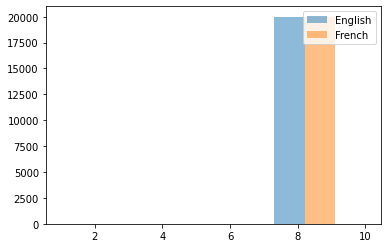

In [ ]:
plt.hist([len(sentence) for sentence in eng_sentences], range=(1,10), alpha=0.5, label="English")
plt.hist([len(sentence) for sentence in fre_sentences], range=(1,10), alpha=0.5, label="French")
plt.legend(loc='upper right')

As we can see, all sentences have the same length, as we expected. Let's see an example of one sentence

In [ ]:
fre_sentences[56]

['<sos>', 'j', 'ai', 'choisi', 'd', 'attendre', '<eos>', '<pad>', '<pad>']

In [ ]:
eng_words, fre_words = list(eng_words), list(fre_words)

# encode each token into index
for i in tqdm(range(len(eng_sentences))):
  eng_sentences[i] = [eng_words.index(x) for x in eng_sentences[i]]
  fre_sentences[i] = [fre_words.index(x) for x in fre_sentences[i]]

idx = 10
print(eng_sentences[idx])
print([eng_words[x] for x in eng_sentences[idx]])
print(fre_sentences[idx])
print([fre_words[x] for x in fre_sentences[idx]])

100%|██████████| 20000/20000 [00:20<00:00, 979.27it/s]

[827, 3672, 5528, 3996, 1580, 154, 1308, 980]
['<sos>', 'he', 'took', 'advantage', 'of', 'every', 'opportunity', '<eos>']
[1264, 3803, 1902, 6810, 8093, 3362, 6347, 4150, 1480]
['<sos>', 'il', 'a', 'saisi', 'toutes', 'les', 'opportunités', 'qui', '<eos>']


In [ ]:
ENG_VOCAB_SIZE = len(eng_words)
FRE_VOCAB_SIZE = len(fre_words)
NUM_EPOCHS = 100
HIDDEN_SIZE = 128
EMBEDDING_DIM = 30
BATCH_SIZE = 128
LEARNING_RATE = 1e-2
DEVICE = torch.device('cuda') 
INITIAL_PATIENCE = 10

In [ ]:
class MTDataset(torch.utils.data.Dataset):
  def __init__(self):
    # import and initialize dataset    
    self.source = np.array(eng_sentences, dtype = int)
    self.target = np.array(fre_sentences, dtype = int)
    
  def __getitem__(self, idx):
    # get item by index
    return self.source[idx], self.target[idx]
  
  def __len__(self):
    # returns length of data
    return len(self.source)

np.random.seed(777)   # for reproducibility
dataset = MTDataset()
NUM_INSTANCES = len(dataset)
TEST_RATIO = 0.3
TEST_SIZE = int(NUM_INSTANCES * 0.3)

indices = list(range(NUM_INSTANCES))

test_idx = np.random.choice(indices, size = TEST_SIZE, replace = False)
train_idx = list(set(indices) - set(test_idx))
train_sampler, test_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = test_sampler)


In [ ]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, hidden_size, embedding_dim, device):
    super(Encoder, self).__init__()
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.device = device
    self.embedding_dim = embedding_dim

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.gru = nn.GRU(embedding_dim, hidden_size)

  def forward(self, x, h0):
    # x = (BATCH_SIZE, MAX_SENT_LEN) = (128, 10)
    x = self.embedding(x)
    x = x.permute(1, 0, 2)
    # x = (MAX_SENT_LEN, BATCH_SIZE, EMBEDDING_DIM) = (10, 128, 30)
    out, h0 = self.gru(x, h0)
    # out = (MAX_SENT_LEN, BATCH_SIZE, HIDDEN_SIZE) = (128, 10, 16)
    # h0 = (1, BATCH_SIZE, HIDDEN_SIZE) = (1, 128, 16)
    return out, h0


In [ ]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, hidden_size, embedding_dim):
    super(Decoder, self).__init__()
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.gru = nn.GRU(embedding_dim, hidden_size)
    self.dense = nn.Linear(hidden_size, vocab_size)
    self.softmax = nn.LogSoftmax(dim = 1)
  
  def forward(self, x, h0):
    # x = (BATCH_SIZE) = (128)
    x = self.embedding(x).unsqueeze(0)
    # x = (1, BATCH_SIZE, EMBEDDING_DIM) = (1, 128, 30)
    x, h0 = self.gru(x, h0)
    x = self.dense(x.squeeze(0))
    x = self.softmax(x)
    return x, h0


In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super(Seq2Seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device

  def forward(self, source, target, tf_ratio = .5):
    # target = (BATCH_SIZE, MAX_SENT_LEN) = (128, 10)
    # source = (BATCH_SIZE, MAX_SENT_LEN) = (128, 10)
    dec_outputs = torch.zeros(target.size(0), target.size(1), self.decoder.vocab_size).to(self.device)
    h0 = torch.zeros(1, source.size(0), self.encoder.hidden_size).to(self.device)
    
    _, h0 = self.encoder(source, h0)
    # dec_input = (BATCH_SIZE) = (128)
    dec_input = target[:, 0]
    
    for k in range(target.size(1)):
      # out = (BATCH_SIZE, VOCAB_SIZE) = (128, XXX)
      # h0 = (1, BATCH_SIZE, HIDDEN_SIZE) = (1, 128, 16)
      out, h0 = self.decoder(dec_input, h0)
      dec_outputs[:, k, :] = out
      dec_input = target[:, k]
      if np.random.choice([True, False], p = [tf_ratio, 1-tf_ratio]):
        dec_input = target[:, k]
      else:
        dec_input = out.argmax(1).detach()

    return dec_outputs

In [ ]:
encoder = Encoder(ENG_VOCAB_SIZE, HIDDEN_SIZE, EMBEDDING_DIM, DEVICE).to(DEVICE)
decoder = Decoder(FRE_VOCAB_SIZE, HIDDEN_SIZE, EMBEDDING_DIM).to(DEVICE)
seq2seq = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr = LEARNING_RATE)

In [ ]:
def train(network, data_loader, optimizer, criterion, train_loss_trace):
  network.train()
  current_loss = 0
  for i, (x, y) in enumerate(data_loader):
    x, y  = x.to(DEVICE), y.to(DEVICE)
    optimizer.zero_grad()
    outputs = network(x, y)
    outputs = outputs.resize(outputs.size(0) * outputs.size(1), outputs.size(-1))
    y = y.resize(y.size(0) * y.size(1))
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
  train_loss_trace.append(current_loss / len(data_loader))

In [ ]:
def test(network, data_loader, criterion, test_loss_trace, test_accuracy_trace):
  network.eval()
  accuracy = 0
  current_loss = 0
  with torch.no_grad():
    for i, (x, y) in enumerate(data_loader):
      x, y  = x.to(DEVICE), y.to(DEVICE)
      outputs = network(x, y)
      outputs = outputs.resize(outputs.size(0) * outputs.size(1), outputs.size(-1))
      y = y.resize(y.size(0) * y.size(1))
      loss = criterion(outputs, y)
      current_loss += loss.item()
      pred = outputs.data.max(1, keepdim=True)[1]
      accuracy += pred.eq(y.data.view_as(pred)).sum()
  test_loss_trace.append(current_loss / len(data_loader)) 
  test_accuracy_trace.append(accuracy.item() / (len(data_loader.dataset) * MAX_FRE_LEN)) 













  0%|          | 0/99 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/tensor.py:358: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")












  1%|          | 1/99 [00:05<09:21,  5.73s/it]

For epoch 1
 Train loss: 4.644983207095753	 Test loss: 4.198804895928565	 Test accuracy: 0.10814444444444445














  2%|▏         | 2/99 [00:11<09:15,  5.72s/it]

For epoch 2
 Train loss: 3.8654367706992407	 Test loss: 3.8449236433556737	 Test accuracy: 0.12240555555555556














  3%|▎         | 3/99 [00:17<09:08,  5.72s/it]

For epoch 3
 Train loss: 3.484452316977761	 Test loss: 3.6167788454826844	 Test accuracy: 0.12867222222222222














  4%|▍         | 4/99 [00:22<09:02,  5.72s/it]

For epoch 4
 Train loss: 3.2296665473417803	 Test loss: 3.5232060868689357	 Test accuracy: 0.13486666666666666














  5%|▌         | 5/99 [00:28<08:58,  5.73s/it]

For epoch 5
 Train loss: 2.966776221448725	 Test loss: 3.4407210654400764	 Test accuracy: 0.13915














  6%|▌         | 6/99 [00:34<08:51,  5.72s/it]

For epoch 6
 Train loss: 2.7942617069591176	 Test loss: 3.4054727655776005	 Test accuracy: 0.14212777777777777














  7%|▋         | 7/99 [00:39<08:45,  5.71s/it]

For epoch 7
 Train loss: 2.64847956570712	 Test loss: 3.4129399543112897	 Test accuracy: 0.14195555555555556














  8%|▊         | 8/99 [00:45<08:40,  5.72s/it]

For epoch 8
 Train loss: 2.5304597074335273	 Test loss: 3.378380115996016	 Test accuracy: 0.14408888888888888














  9%|▉         | 9/99 [00:51<08:35,  5.73s/it]

For epoch 9
 Train loss: 2.4021821000359274	 Test loss: 3.447811522382371	 Test accuracy: 0.1431611111111111














 10%|█         | 10/99 [00:57<08:29,  5.73s/it]

For epoch 10
 Train loss: 2.333201865716414	 Test loss: 3.4181473711703685	 Test accuracy: 0.14355555555555555














 11%|█         | 11/99 [01:02<08:22,  5.71s/it]

For epoch 11
 Train loss: 2.251508180661635	 Test loss: 3.44636869430542	 Test accuracy: 0.14517222222222223














 12%|█▏        | 12/99 [01:08<08:15,  5.69s/it]

For epoch 12
 Train loss: 2.170490518483249	 Test loss: 3.3935971716617015	 Test accuracy: 0.1472














 13%|█▎        | 13/99 [01:14<08:10,  5.70s/it]

For epoch 13
 Train loss: 2.074116004597057	 Test loss: 3.450907752868977	 Test accuracy: 0.1459














 14%|█▍        | 14/99 [01:19<08:03,  5.69s/it]

For epoch 14
 Train loss: 1.978364429690621	 Test loss: 3.5221485635067555	 Test accuracy: 0.14555555555555555














 15%|█▌        | 15/99 [01:25<07:59,  5.71s/it]

For epoch 15
 Train loss: 1.9292199319059198	 Test loss: 3.45915916118216	 Test accuracy: 0.14748333333333333














 16%|█▌        | 16/99 [01:31<07:53,  5.71s/it]

For epoch 16
 Train loss: 1.8041571183638139	 Test loss: 3.4757746128325766	 Test accuracy: 0.14909444444444445














 17%|█▋        | 17/99 [01:37<07:47,  5.70s/it]

For epoch 17
 Train loss: 1.765309948270971	 Test loss: 3.538368306261428	 Test accuracy: 0.14752222222222222














 18%|█▊        | 18/99 [01:42<07:41,  5.70s/it]

For epoch 18
 Train loss: 1.696600125052712	 Test loss: 3.5328207472537425	 Test accuracy: 0.14956111111111112


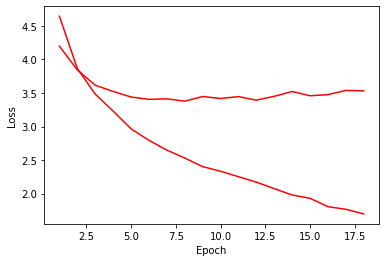

CPU times: user 1min 30s, sys: 11.6 s, total: 1min 42s
Wall time: 1min 42s


In [ ]:
%%time
train_loss_trace = []
test_loss_trace = []
accuracy_trace = []
patience = INITIAL_PATIENCE
min_loss = 100000
for epoch in tqdm(range(1, NUM_EPOCHS)):
  if patience == 0:
    break
  train(seq2seq, train_loader, optimizer, criterion, train_loss_trace)
  test(seq2seq, test_loader, criterion, test_loss_trace, accuracy_trace)
  print(f"For epoch {epoch}\n Train loss: {train_loss_trace[-1]}\t Test loss: {test_loss_trace[-1]}\t Test accuracy: {accuracy_trace[-1]}")
  current_loss = test_loss_trace[-1]
  if current_loss < min_loss:
    min_loss = current_loss
    patience = INITIAL_PATIENCE
    best_model = copy.deepcopy(seq2seq)
  else:
    patience -= 1
# loss curve
plt.plot(range(1, epoch), train_loss_trace, 'r-', label = "train")
plt.plot(range(1, epoch), test_loss_trace, 'r-', label = "test")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
!pip install torchtext==0.7.0
from torchtext.data.metrics import bleu_score

def evaluate_bleu_score(network, data_loader):
  network.eval()
  BLEU_score = 0
  original_sentences = [None] * len(data_loader.dataset)
  predicted_sentences = [None] * len(data_loader.dataset)
  global_counter = 0
  with torch.no_grad():
    for i, (x, y) in enumerate(data_loader):
      outputs = network(x, y)
      for sentence, prediction in zip(y, outputs):
        original_sentence[global_counter] = [fre_words[word_idx] for word_idx in sentence] 
        predicted_sentence[global_counter] = [fre_words[word_idx] for word_idx in prediction]
      print(original_sentence, predicted_sentence)
      break

     |████████████████████████████████| 4.5MB 2.8MB/s 
  Found existing installation: torchtext 0.6.0
    Uninstalling torchtext-0.6.0:
      Successfully uninstalled torchtext-0.6.0


ImportError: ignored

In [ ]:
evaluate_bleu_score(best_model, test_loader)